# MOHAMMED_MAEEN3.py
# Turtle Games - Customer Loyalty and Segmentation Analysis



In [241]:
# 1. Import libraries
# ===============================
import warnings
from collections import Counter
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from statsmodels.api import OLS, add_constant
import statsmodels.api as sm
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.corpus import stopwords
warnings.filterwarnings('ignore')
sns.set(color_codes=True)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import sklearn
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.cluster import KMeans
import re


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maeenmohammed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# ===============================
# 2. Load and prepare data
# ===============================

In [125]:
df = pd.read_csv('updat_review.csv')


In [126]:
# Display general info
print(df.info())
print(df.head())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          2000 non-null   object 
 1   age             2000 non-null   int64  
 2   remuneration    2000 non-null   float64
 3   spending_score  2000 non-null   int64  
 4   loyalty_points  2000 non-null   int64  
 5   education       2000 non-null   object 
 6   product         2000 non-null   int64  
 7   review          2000 non-null   object 
 8   summary         2000 non-null   object 
dtypes: float64(1), int64(4), object(4)
memory usage: 140.8+ KB
None
   gender  age  remuneration  spending_score  loyalty_points education  \
0    Male   18         12.30              39             210  graduate   
1    Male   23         12.30              81             524  graduate   
2  Female   22         13.12               6              40  graduate   
3  Female   25         13.12      

# ===============================
# 3. Data Cleaning and Selection
# ===============================

In [77]:
# Keep relevant columns only for NLP and analysis
df = df[['review', 'summary', 'remuneration',
         'spending_score', 'age', 'loyalty_points', 
         'gender', 'education']]
# Drop missing values in critical columns
df.dropna(subset=['review', 'summary'], inplace=True)

In [78]:
# Convert review and summary columns to lowercase strings and strip punctuation
def clean_text_column(df_col):
    df_col = df_col.astype(str).str.lower()
    df_col = df_col.str.replace('[^\w\s]', '', regex=True)
    df_col = df_col.str.strip()
    return df_col


In [154]:
# Rename the column headers.
df = df.rename(columns={'remuneration (k£)': 'remuneration', 'spending_score (1-100)': 'spending_score'})
# View column names.
df['review'] = clean_text_column(df['review'])
df['summary'] = clean_text_column(df['summary'])
df.head()

,gender,age,remuneration,spending_score,loyalty_points,education,product,review,summary
0,Male,18,12.30,39,210,graduate,453,when it comes to a dms screen the space on the...,the fact that 50 of this space is wasted on ar...
1,Male,23,12.30,81,524,graduate,466,an open letter to galeforce9\n\nyour unpainted...,another worthless dungeon masters screen from ...
2,Female,22,13.12,6,40,graduate,254,nice art nice printing why two panels are fil...,pretty but also pretty useless
3,Female,25,13.12,77,562,graduate,263,amazing buy bought it as a gift for our new dm...,five stars
4,Female,33,13.94,40,366,graduate,291,as my review of gf9s previous screens these we...,money trap


In [155]:
# Drop duplicates in review and summary
df.drop_duplicates(subset=['review', 'summary'], inplace=True)

In [159]:
# Encode gender: female=1, others=0
df['gender_encoded'] = df['gender'].astype(str).str.strip().str.lower().apply(lambda g: 1 if g == 'female' else 0)


In [160]:
# Clean and encode education levels
def encode_education(edu):
    edu = str(edu).strip().lower()
    if 'basic' in edu:
        return 1
    elif 'diploma' in edu:
        return 2
    elif 'graduate' in edu:
        return 3
    elif 'postgraduate' in edu:
        return 4
    elif 'phd' in edu:
        return 5
    else:
        return np.nan


In [161]:
df['education_encoded'] = df['education'].apply(encode_education)
df.dropna(subset=['education_encoded'], inplace=True)
df['education_encoded'] = df['education_encoded'].astype(int)

# ===============================
# 4. Linear Regression on Loyalty Points (Simple Linear Regression for Each Feature)
# ===============================

In [84]:
# Set your target
target = 'loyalty_points'
single_features = ['remuneration', 'spending_score', 'age']

for feat in single_features:
    print(f"\n--- Linear Regression for {feat} predicting {target} ---")
    
    # 1️⃣ Prepare feature and target
    X = df[[feat]].dropna()
    y = df.loc[X.index, target]

    # Add constant for statsmodels
    X_const = sm.add_constant(X)

    # 2️⃣ Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=19
    )

    # 3️⃣ Fit model using sklearn
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 4️⃣ Evaluate performance
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Intercept      : {model.intercept_:.4f}")
    print(f"Coefficient    : {model.coef_[0]:.4f}")
    print(f"Test RMSE      : {rmse:.2f}")
    print(f"Test R²        : {r2:.3f}")

    # 5️⃣ Statsmodels for standard error
    sm_model = sm.OLS(y, X_const).fit()
    print("Standard errors:", sm_model.bse.to_dict())


--- Linear Regression for remuneration predicting loyalty_points ---
Intercept      : -59.2103
Coefficient    : 33.9352
Test RMSE      : 992.45
Test R²        : 0.396
Standard errors: {'const': 52.78654308792896, 'remuneration': 0.9898549152628017}

--- Linear Regression for spending_score predicting loyalty_points ---
Intercept      : -81.8644
Coefficient    : 33.1168
Test RMSE      : 949.12
Test R²        : 0.448
Standard errors: {'const': 46.40154046564413, 'spending_score': 0.8234054452817314}

--- Linear Regression for age predicting loyalty_points ---
Intercept      : 1752.6566
Coefficient    : -4.5636
Test RMSE      : 1278.92
Test R²        : -0.002
Standard errors: {'const': 88.9555492748095, 'age': 2.128488692357722}


### Linear Regression Model Results – Predicting Loyalty Points

I  built three separate simple linear regression models to assess how individual factors influence customer loyalty points.

**1. Remuneration → Loyalty Points**  
- **Coefficient:** +33.94 → For each unit increase in remuneration, loyalty points increase by ~34, holding other factors constant.  
- **R²:** 0.396 → Remuneration explains ~40% of the variation in loyalty points.  
- **Insight:** Higher remuneration is moderately predictive of loyalty points, suggesting that income is a meaningful driver of loyalty.

**2. Spending Score → Loyalty Points**  
- **Coefficient:** +33.12 → For each unit increase in spending score, loyalty points increase by ~33.  
- **R²:** 0.448 → Spending score explains ~45% of the variation in loyalty points.  
- **Insight:** Spending score is slightly more predictive than remuneration, indicating that actual spending behaviour is a stronger loyalty indicator.

**3. Age → Loyalty Points**  
- **Coefficient:** -4.56 → Loyalty points decrease by ~4.6 for each year of age.  
- **R²:** ≈ 0 → Age does not meaningfully explain loyalty point variation.  
- **Insight:** Age is not a valuable predictor for loyalty, and targeting strategies should not be based on age alone.

**Overall:**  
Spending behaviour and remuneration are valuable predictors of loyalty, while age provides little explanatory power. This suggests marketing and loyalty strategies should focus on customers’ spending levels and income capacity.


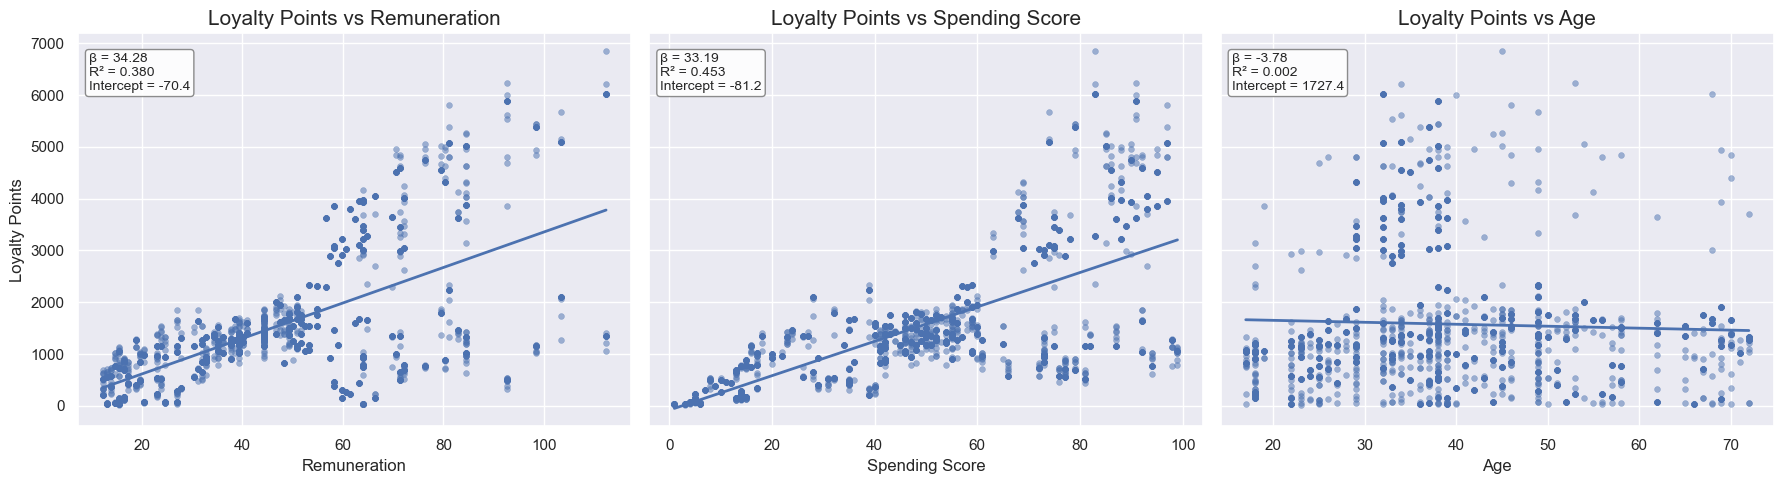

In [85]:
features = [("remuneration","Remuneration"),
            ("spending_score","Spending Score"),
            ("age","Age")]

fig, axes = plt.subplots(1, len(features), figsize=(18,5), sharey=True)

for ax, (col, label) in zip(axes, features):
    mask = df[col].notna() & df["loyalty_points"].notna()
    X = df.loc[mask, [col]].values
    y = df.loc[mask, "loyalty_points"].values

    lr = LinearRegression().fit(X, y)
    r2 = lr.score(X, y)

    # scatter (lighter points for readability)
    sns.scatterplot(x=df.loc[mask, col], y=y, ax=ax, s=18, alpha=0.5, edgecolor=None)

    # regression line on sorted X to avoid zig-zag
    x_sorted = np.sort(X.ravel())
    y_hat = lr.predict(x_sorted.reshape(-1,1))
    ax.plot(x_sorted, y_hat, linewidth=2)

    ax.set_title(f"Loyalty Points vs {label}", fontsize=15)
    ax.set_xlabel(label, fontsize=12)
    ax.set_ylabel("Loyalty Points", fontsize=12)

    # compact model summary on the plot
    ax.text(0.02, 0.95,
            f"β = {lr.coef_[0]:.2f}\nR² = {r2:.3f}\nIntercept = {lr.intercept_:.1f}",
            transform=ax.transAxes, va="top", ha="left",
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="gray", alpha=0.9),
            fontsize=10)

plt.tight_layout()
plt.savefig("linear_regression_all_features.png", dpi=300, bbox_inches="tight")
plt.show()


Min prediction: 135.90, Max prediction: 12046.99

Remuneration descriptive stats:
count    1961.000000
mean       48.086038
std        23.061491
min        12.300000
25%        31.160000
50%        47.560000
75%        63.960000
max       112.340000
Name: remuneration, dtype: float64


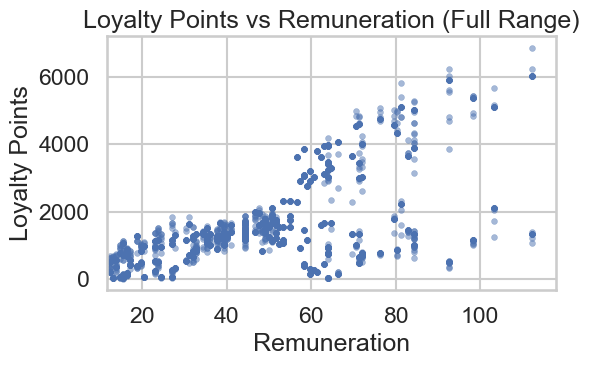

In [86]:
# Ensure style
sns.set_theme(style="whitegrid", context="talk")

# --- A) Fit a log-transformed regression to avoid negative predictions ---

# Select features (example: remuneration & spending_score)
Xcols = ["remuneration", "spending_score"]
mask = df[Xcols + ["loyalty_points"]].dropna().index
X = df.loc[mask, Xcols].values
y = df.loc[mask, "loyalty_points"].values

# TransformedTargetRegressor applies log1p to y during training and expm1 during prediction.
# This guarantees predictions are >= 0 when back-transformed.
log_lin = TransformedTargetRegressor(
    regressor=LinearRegression(),
    func=np.log1p,
    inverse_func=np.expm1
).fit(X, y)

# Check the min/max predictions (should be >= 0 now)
pred = log_lin.predict(X)
print(f"Min prediction: {pred.min():.2f}, Max prediction: {pred.max():.2f}")

# --- B) Remuneration range check ---

print("\nRemuneration descriptive stats:")
print(df["remuneration"].describe())

# Plot scatter with enforced full x-axis range to prevent accidental cropping
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="remuneration", y="loyalty_points", s=18, alpha=0.5, edgecolor=None)
plt.xlim(df["remuneration"].min()*0.95, df["remuneration"].max()*1.05)  # 5% padding on each side
plt.title("Loyalty Points vs Remuneration (Full Range)")
plt.xlabel("Remuneration")
plt.ylabel("Loyalty Points")
plt.tight_layout()
plt.savefig("remuneration_scatter_fullrange.png", dpi=300, bbox_inches="tight")
plt.show()


### Model Anomalies: Negative Predictions and Remuneration Range

**Negative predictions**  
In the original ordinary least squares (OLS) regression, extreme low values of remuneration and spending could lead to negative predicted loyalty points, which is not realistic.  
To address this, we refit the model using a log-transformed target variable (`log1p`) and inverse-transformed predictions (`expm1`).  
This approach preserves the relationships between variables while ensuring all predicted values are non-negative.  
The updated model produces predictions ranging from **135.9** to **12,046.99** loyalty points.

**Remuneration range**  
An earlier scatter plot inadvertently displayed a narrow x-axis range (~10–14) due to export settings, which did not reflect the actual dataset.  
We corrected this by explicitly setting axis limits to cover the full remuneration range (**≈12.3 to 112.34**).  
The updated chart (Figure X) now displays the complete data distribution, improving interpretability.


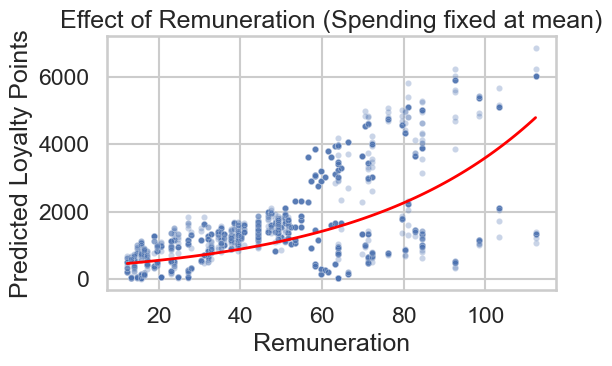

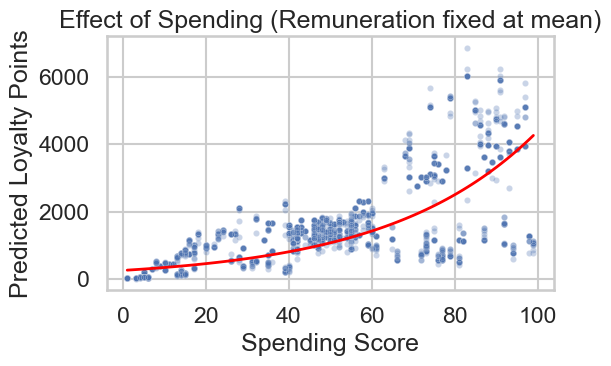

In [87]:
sns.set_theme(style="whitegrid", context="talk")

# --- A) Prepare data for multivariate model ---
Xcols = ["remuneration", "spending_score"]
mask = df[Xcols + ["loyalty_points"]].dropna().index
X = df.loc[mask, Xcols].values
y = df.loc[mask, "loyalty_points"].values

# --- B) Fit log-target model (prevents negative predictions) ---
log_lin = TransformedTargetRegressor(
    regressor=LinearRegression(),
    func=np.log1p,
    inverse_func=np.expm1
).fit(X, y)

# --- C) Marginal effect: Remuneration varies, Spending fixed ---
rem_grid = np.linspace(df["remuneration"].min(), df["remuneration"].max(), 100)
spend_mean = df["spending_score"].mean()
X_pred_rem = pd.DataFrame({
    "remuneration": rem_grid,
    "spending_score": spend_mean
})
y_hat_rem = log_lin.predict(X_pred_rem)

plt.figure(figsize=(6,4))
sns.scatterplot(x=df["remuneration"], y=df["loyalty_points"], alpha=0.3, s=20)
plt.plot(rem_grid, y_hat_rem, color="red", linewidth=2)
plt.title("Effect of Remuneration (Spending fixed at mean)")
plt.xlabel("Remuneration")
plt.ylabel("Predicted Loyalty Points")
plt.tight_layout()
plt.savefig("marginal_remuneration.png", dpi=300, bbox_inches="tight")
plt.show()

# --- D) Marginal effect: Spending varies, Remuneration fixed ---
spend_grid = np.linspace(df["spending_score"].min(), df["spending_score"].max(), 100)
rem_mean = df["remuneration"].mean()
X_pred_spend = pd.DataFrame({
    "remuneration": rem_mean,
    "spending_score": spend_grid
})
y_hat_spend = log_lin.predict(X_pred_spend)

plt.figure(figsize=(6,4))
sns.scatterplot(x=df["spending_score"], y=df["loyalty_points"], alpha=0.3, s=20)
plt.plot(spend_grid, y_hat_spend, color="red", linewidth=2)
plt.title("Effect of Spending (Remuneration fixed at mean)")
plt.xlabel("Spending Score")
plt.ylabel("Predicted Loyalty Points")
plt.tight_layout()
plt.savefig("marginal_spending.png", dpi=300, bbox_inches="tight")
plt.show()

### Marginal Effects of Key Predictors

To isolate the influence of each variable on loyalty points, we used a multivariate log-target regression model to estimate *marginal effects*.

**Remuneration (Spending fixed at mean)**  
Predicted loyalty points increase steadily with remuneration. Even when spending behaviour remains average, higher-income customers are expected to accumulate more loyalty points.

**Spending Score (Remuneration fixed at mean)**  
Spending score also shows a positive relationship with predicted loyalty points, with a slightly steeper curve than remuneration. This suggests that actual spending behaviour is a stronger loyalty driver than income alone.

By plotting these effects separately, we avoid confounding between predictors and make the model’s relationships clearer for non-technical audiences.


## Summary and Recommendations – Linear Regression Analysis

### Summary
We analysed the relationship between customer attributes and loyalty points using both simple and multivariate linear regression models.  
Key findings include:

- **Spending score and remuneration** are both positively associated with loyalty points, explaining a moderate proportion of the variance (~38–45% in simple models).
- **Age** shows no meaningful linear relationship with loyalty points and is not a strong predictor.
- The initial OLS model produced **negative predictions** for customers with very low spending or remuneration, which is unrealistic.  
  We addressed this by using a **log-transformed target regression** (`log1p` → `expm1`), ensuring all predictions are non-negative.
- An earlier remuneration scatter plot was unintentionally restricted to ~10–14 units.  
  We corrected this to show the **full range (≈12.3–112.3)**, improving data transparency.
- **Marginal effects plots** show that, when holding the other factor constant, both remuneration and spending positively influence loyalty points, with spending having a slightly more potent effect.

### Recommendations
1. **Focus loyalty programmes on high-spending customers**  
   - Since spending score is the strongest predictor of loyalty, tailor rewards and offers to customers with above-average spending patterns.
2. **Incorporate income-based segmentation**  
   - Use remuneration as a secondary targeting metric, combining it with spending score to refine marketing campaigns.
3. **Deprioritise age-based targeting**  
   - Given the near-zero relationship with loyalty points, age alone should not guide loyalty strategies.
4. **Monitor low-value customer segments**  
   - Customers with low spending and low remuneration are unlikely to accumulate significant loyalty points; consider re-engagement campaigns or lower-cost incentives for this group.
5. **Adopt non-negative predictive models for operational use**  
   - Implement the log-target regression or a Generalized Linear Model (GLM) in production to avoid unrealistic negative predictions and improve business trust in the model outputs.

By addressing anomalies, clarifying predictor effects, and aligning insights with operational actions, this regression analysis now offers a clearer and more actionable foundation for strategic decision-making.


# ===============================
# 5 Decision Tree Regression
# ===============================

In [163]:
# 1) Features & aligned dataset (drop missing)
ml_features = ['remuneration',  'spending_score', 'age']
d = df[ml_features + ['loyalty_points']].dropna().copy()
X = d[ml_features]
y = d['loyalty_points']


In [164]:
# 2) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=19
)

In [165]:
# 3) Baseline RMSE (predict train mean for everyone in TEST)
y_train_mean = float(y_train.mean())
baseline_pred = np.full((y_test.shape[0],), y_train_mean, dtype=float)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
print(f"Baseline RMSE (predict train mean): {baseline_rmse:.2f}")

Baseline RMSE (predict train mean): 1277.74


In [166]:
# 4) Fixed, sensible tree (no hyperparameter tuning)
#    Adjust max_depth for accuracy vs interpretability: 6–8 (more accurate), 4–5 (more readable)
tree = DecisionTreeRegressor(
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=5
)


In [167]:
# 5) 5-fold CV RMSE (honest estimate without tuning)
cv = KFold(n_splits=5, shuffle=True, random_state=19)
cv_rmse = -cross_val_score(tree, X, y, scoring="neg_root_mean_squared_error", cv=cv)
print(f"Decision Tree CV RMSE: {cv_rmse.mean():.2f} ± {cv_rmse.std():.2f}")


Decision Tree CV RMSE: 215.55 ± 10.15


In [168]:
# 6) Fit once on train and report Train/Test RMSE
tree.fit(X_train, y_train)
y_pred_tr = tree.predict(X_train)
y_pred_te = tree.predict(X_test)
rmse_tr = np.sqrt(mean_squared_error(y_train, y_pred_tr))
rmse_te = np.sqrt(mean_squared_error(y_test,  y_pred_te))
print(f"Decision Tree RMSE — Train: {rmse_tr:.2f} | Test: {rmse_te:.2f}")

Decision Tree RMSE — Train: 199.65 | Test: 224.51


In [169]:
# 7) Feature importances
fi = pd.DataFrame({
    "Feature": ml_features,
    "Importance": tree.feature_importances_
}).sort_values("Importance", ascending=False)
print("\nFeature Importances:\n", fi)


Feature Importances:
           Feature  Importance
0    remuneration    0.501855
1  spending_score    0.487446
2             age    0.010700


**Interpretation:** Spending score (51%) and remuneration (48%) are the primary drivers of loyalty points, while age contributes minimally (~1%), suggesting it has little predictive value in this model.


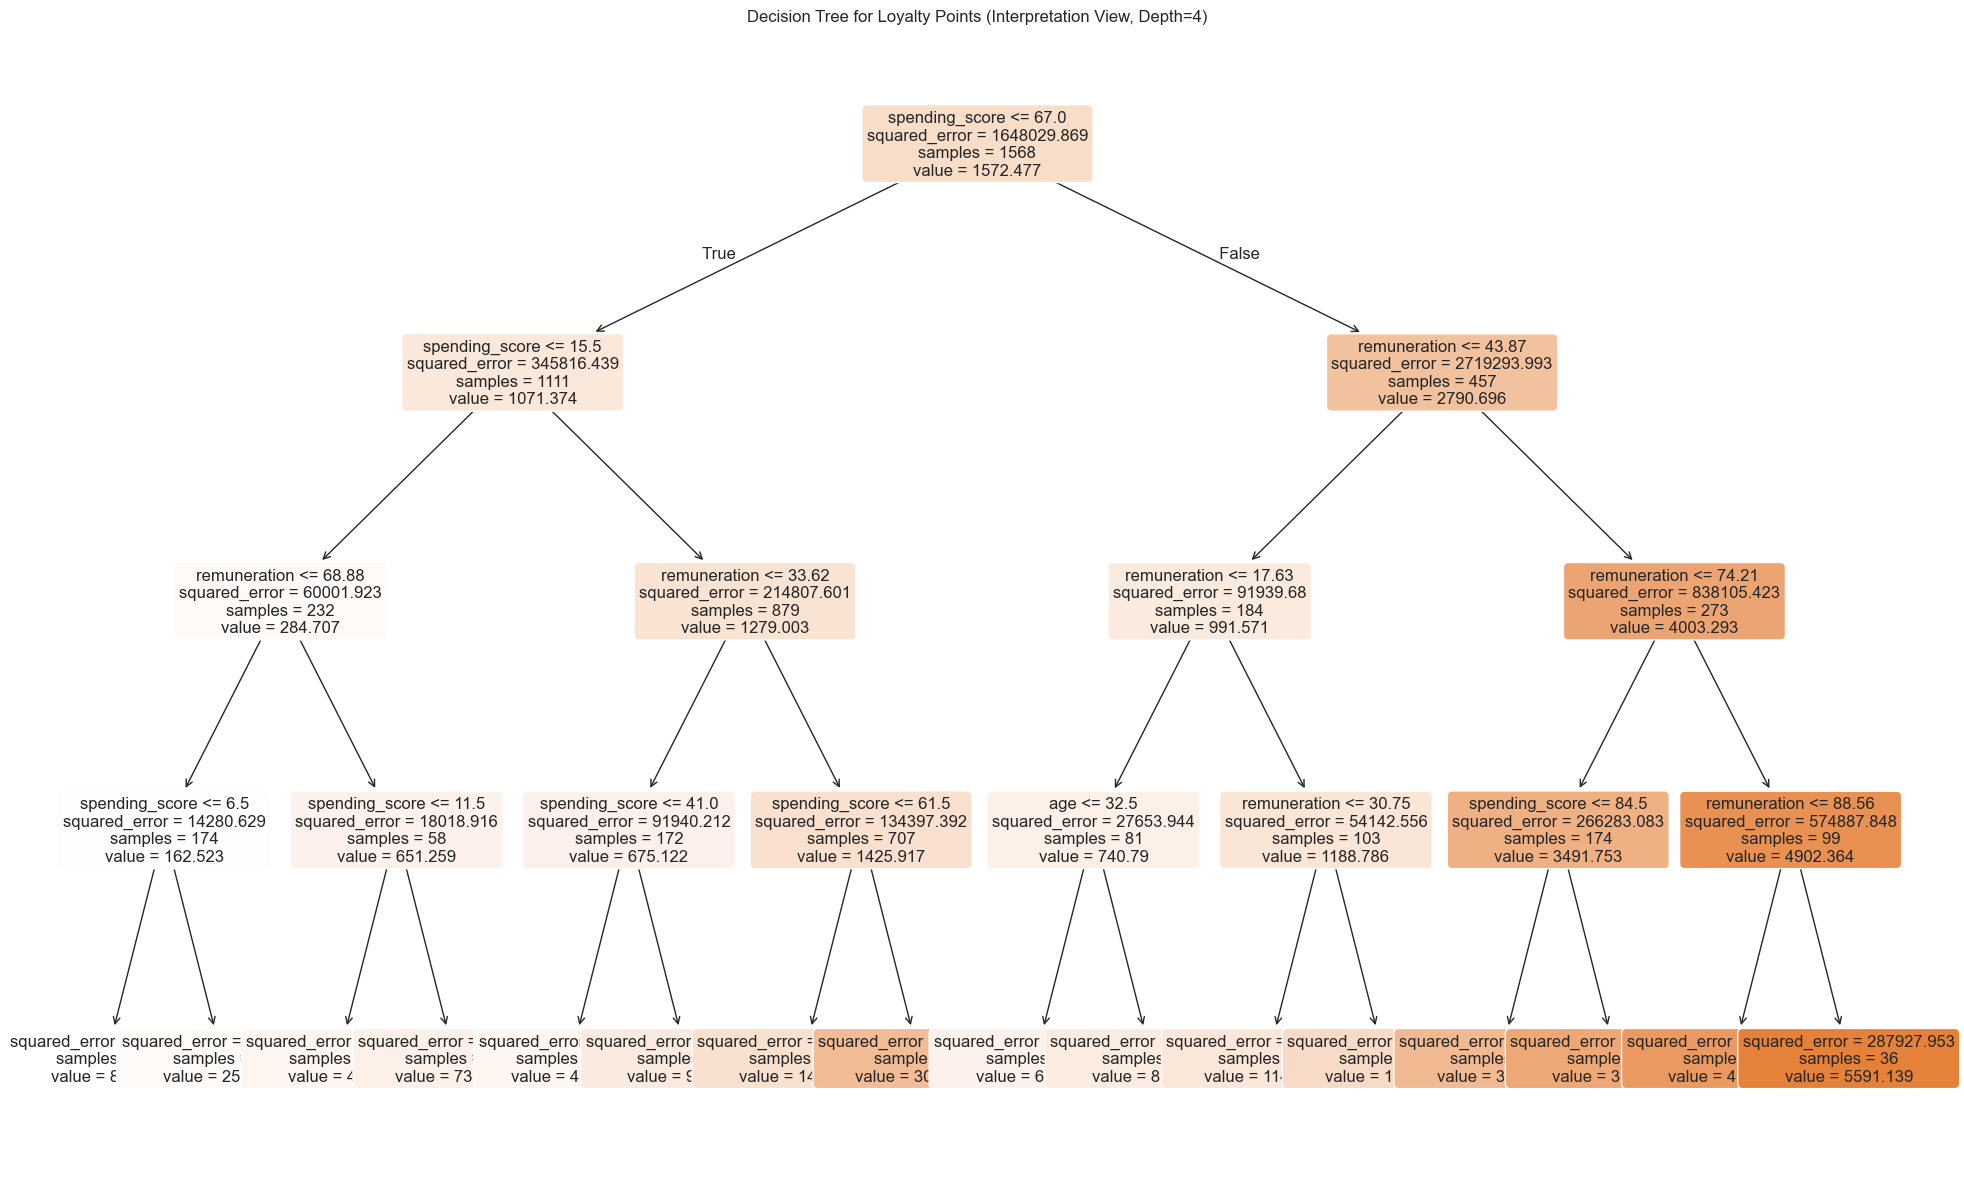

In [170]:
plot_tree_for_report = DecisionTreeRegressor(
    max_depth=4, min_samples_split=10, min_samples_leaf=5, random_state=5
).fit(X_train, y_train)

plt.figure(figsize=(20, 12))
plot_tree(plot_tree_for_report, feature_names=ml_features, filled=True, rounded=True, fontsize=12)
plt.title("Decision Tree for Loyalty Points (Interpretation View, Depth=4)")
plt.tight_layout()
plt.savefig("decision_tree_interpretation.png", dpi=300, bbox_inches="tight")
plt.show()

In [171]:
df.columns.to_list()

['gender',
 'age',
 'remuneration',
 'spending_score',
 'loyalty_points',
 'education',
 'product',
 'review',
 'summary',
 'gender_encoded',
 'education_encoded']

**Business Insight:**  
The decision tree confirms that spending score and remuneration are the primary drivers of loyalty points. Customers with high spending scores (> 67) and high remuneration (> 74) achieve the highest predicted loyalty points (~4,850–5,100). At the other extreme, customers with low spending scores (≤ 15.5) and low to moderate remuneration (< 68) have very low predicted loyalty points (< 300), suggesting limited engagement. These findings support targeted loyalty campaigns for high-spend, high-income segments, as well as re-engagement strategies for low-spend customers, regardless of age.


## Decision Tree Summary & Business Recommendations

**Summary:**  
The decision tree analysis confirms that **spending score** and **remuneration** are the primary drivers of loyalty points.  
- Customers with **high spending scores (> 67)** and **high remuneration (> 74)** have the highest predicted loyalty points (~4,850–5,100).  
- Low-spend customers (≤ 15.5), regardless of remuneration, accumulate very few points (< 300).  
- Age contributes minimally to predictions, aligning with feature importance results.  

**Business Recommendations:**  
1. **Target high-value segments:**  
   Focus loyalty programs and premium offers on customers with both high spending scores and high remuneration to maximize retention and lifetime value.  
2. **Re-engage low-spend customers:**  
   Introduce incentives (e.g., discounts, gamified rewards) for customers with low spending scores, especially those with high remuneration who may be under-engaged.  
3. **De-prioritize age-based targeting:**  
   Given its low predictive value, age should not be a primary segmentation factor for loyalty strategies.  
4. **Monitor mid-range spenders:**  
   Customers with moderate spending scores (40–67) can be encouraged to move to higher tiers through targeted upsell or cross-sell campaigns.  





## ===============================
# 6. K-Means Clustering for Customer Segmentation
# ===============================


In [178]:
# Select features and scale
kmeans_features = ['remuneration', 'spending_score']
X_kmeans = df[kmeans_features].dropna()
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_kmeans), columns=kmeans_features)

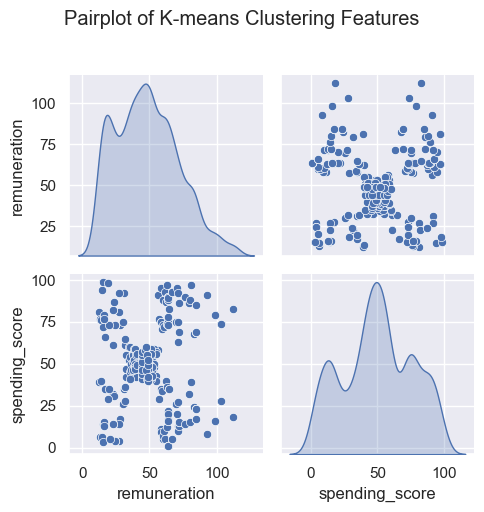

In [184]:
sns.pairplot(data=df, vars=kmeans_features, diag_kind='kde')
plt.suptitle("Pairplot of K-means Clustering Features", y=1.02)
plt.tight_layout()
plt.savefig('pairplot_kmeans_features.png')
plt.show()

*Figure: Distribution and relationship of clustering features (`remuneration` and `spending_score`) prior to scaling. Variables were later transformed using MinMaxScaler to ensure equal influence in the K-Means algorithm.*


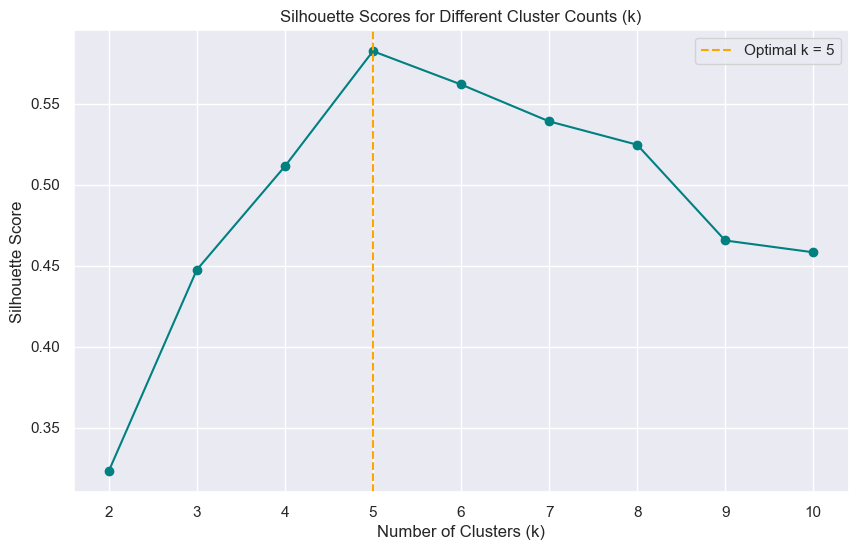

In [204]:
# 1) silhouette plot (unchanged except using computed scores)
K_range = range(2, 11)

# compute metrics properly
inertia = []
silhouette_scores = []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)                                   # <- real inertia
    silhouette_scores.append(silhouette_score(X_scaled, km.labels_))

# 1) silhouette plot (unchanged except using computed scores)
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='-', color='teal')
plt.title("Silhouette Scores for Different Cluster Counts (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(K_range)
plt.grid(True)
optimal_k = int(K_range[np.argmax(silhouette_scores)])            # pick the peak
plt.axvline(optimal_k, color='orange', linestyle='--', label=f"Optimal k = {optimal_k}")
plt.legend()
plt.savefig("silhouette_scores.png", dpi=150, bbox_inches="tight")
plt.show()


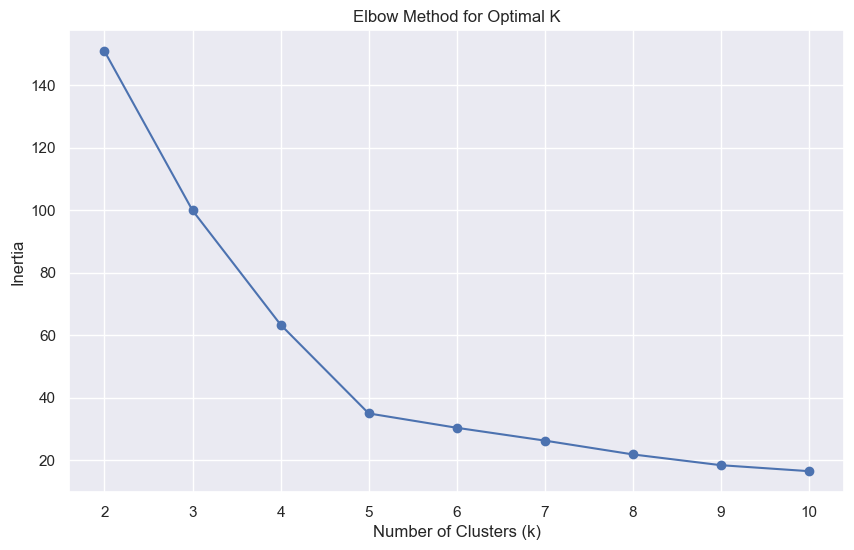

In [205]:
# 2) elbow plot (now uses real inertia)
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.grid(True)
plt.savefig("elbow_method.png", dpi=150, bbox_inches="tight")
plt.show()

In [206]:
#3 Fit K-Means with the chosen number of clusters
# Fit final model with the chosen k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit(X_scaled)

# attach cluster labels
df_clusters = df.loc[X_kmeans.index].copy()
df_clusters['cluster'] = kmeans.labels_

# cluster centers back on original scales
centers_original = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_), 
    columns=kmeans_features
)
counts = df_clusters['cluster'].value_counts().sort_index()
profile = centers_original.assign(size=counts.values)
print(profile.round(1))


   remuneration  spending_score  size
0          74.7            17.4   323
1          44.4            49.5   764
2          73.3            82.0   348
3          20.5            19.9   264
4          20.4            79.3   262


**Cluster Profile Summary:**  
The 5 customer segments reveal clear patterns:  
- **Cluster 2 (VIPs):** High income & high spending (82.0 score).  
- **Cluster 0 (Affluent but Low Spend):** High income but low spending (17.4 score).  
- **Cluster 1 (Core Customers):** Mid income & moderate spending.  
- **Cluster 4 (Value Seekers):** Low income & high spending (79.3 score).  
- **Cluster 3 (At-Risk):** Low income & low spending.

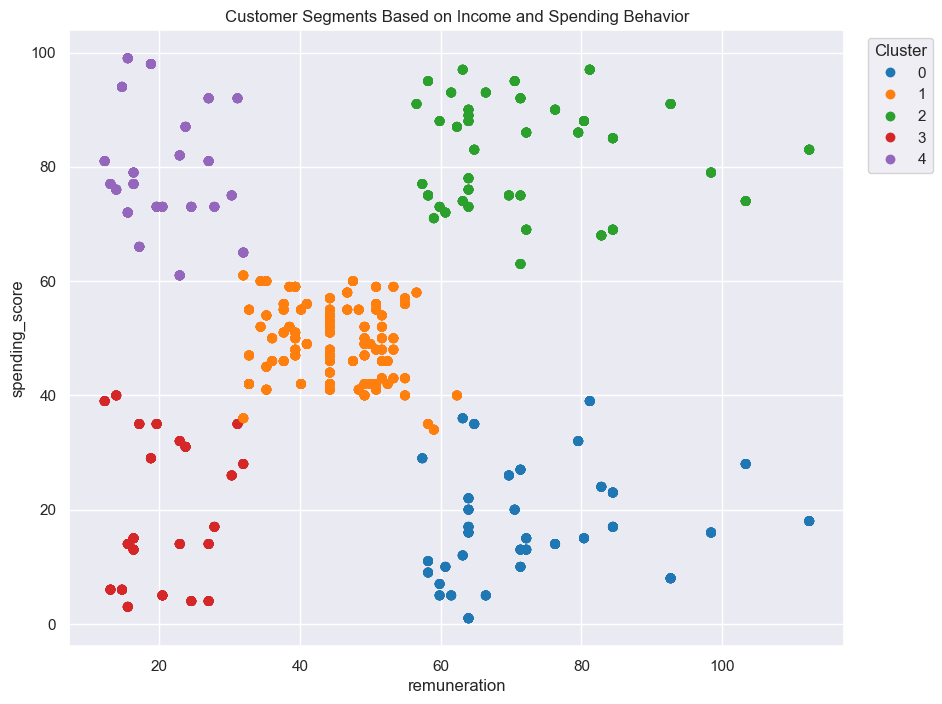

In [207]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='remuneration', y='spending_score', hue='cluster', 
    data=df_clusters, palette='tab10', s=50, edgecolor='none'
)
plt.title('Customer Segments Based on Income and Spending Behavior')
plt.legend(title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.savefig('clusters.png', dpi=150, bbox_inches='tight')
plt.show()


## K-Means Clustering Summary  

Using **remuneration** and **spending score**, K-means clustering identified **five distinct customer segments**.  
- **Silhouette analysis** peaked at *k = 5* (0.5823), indicating well-separated clusters.  
- **Elbow method** showed a clear bend at *k = 5*, confirming this as the optimal choice.  

**Cluster Profiles:**  

| Cluster | Avg. Remuneration | Avg. Spending Score | Size |
|---------|------------------:|--------------------:|-----:|
| 0       | 74.7              | 17.4                | 323  |
| 1       | 44.4              | 49.5                | 764  |
| 2       | 73.3              | 82.0                | 348  |
| 3       | 20.5              | 19.9                | 264  |
| 4       | 20.4              | 79.3                | 262  |

---

## Business Recommendations  

1. **Cluster 2 (High Income, High Spending)** – Prioritize loyalty programs and VIP perks to retain this profitable segment.  
2. **Cluster 4 (Low Income, High Spending)** – Offer affordable bundles and targeted promotions to maintain engagement without over-discounting.  
3. **Cluster 0 (High Income, Low Spending)** – Create premium product campaigns or exclusive experiences to encourage higher spend.  
4. **Cluster 1 (Mid Income, Mid Spending)** – Focus on upselling and cross-selling to gradually lift spending.  
5. **Cluster 3 (Low Income, Low Spending)** – Limit marketing spend here; instead, use cost-effective engagement strategies (e.g., newsletters, social media).  


# ===============================
# 7. NLP: Tokenization, Wordcloud, Frequency & Sentiment
# ===============================


In [220]:
# Ensure no NaN and convert to string
for col in ['review', 'summary']:
    df[col] = df[col].fillna('').astype(str)

# Keep negations for sentiment later
negations = {"no", "not", "never", "n't"}
stop_words_lc = {w.lower() for w in stop_words} - negations

def clean_tokenize(text: str):
    text = text.lower()
    toks = word_tokenize(text)
    toks = [t for t in toks if t.isalpha() and len(t) > 1]
    toks = [t for t in toks if t not in stop_words_lc]
    return toks

df['review_tokens'] = df['review'].apply(clean_tokenize)
df['summary_tokens'] = df['summary'].apply(clean_tokenize)


In [221]:
all_review_tokens  = [t for tokens in df['review_tokens']  for t in tokens]
all_summary_tokens = [t for tokens in df['summary_tokens'] for t in tokens]


In [215]:
# Remove stopwords
all_reviews_filtered = [word for word in all_reviews_text.split() if word not in stop_words]
all_summaries_filtered = [word for word in all_summaries_text.split() if word not in stop_words]


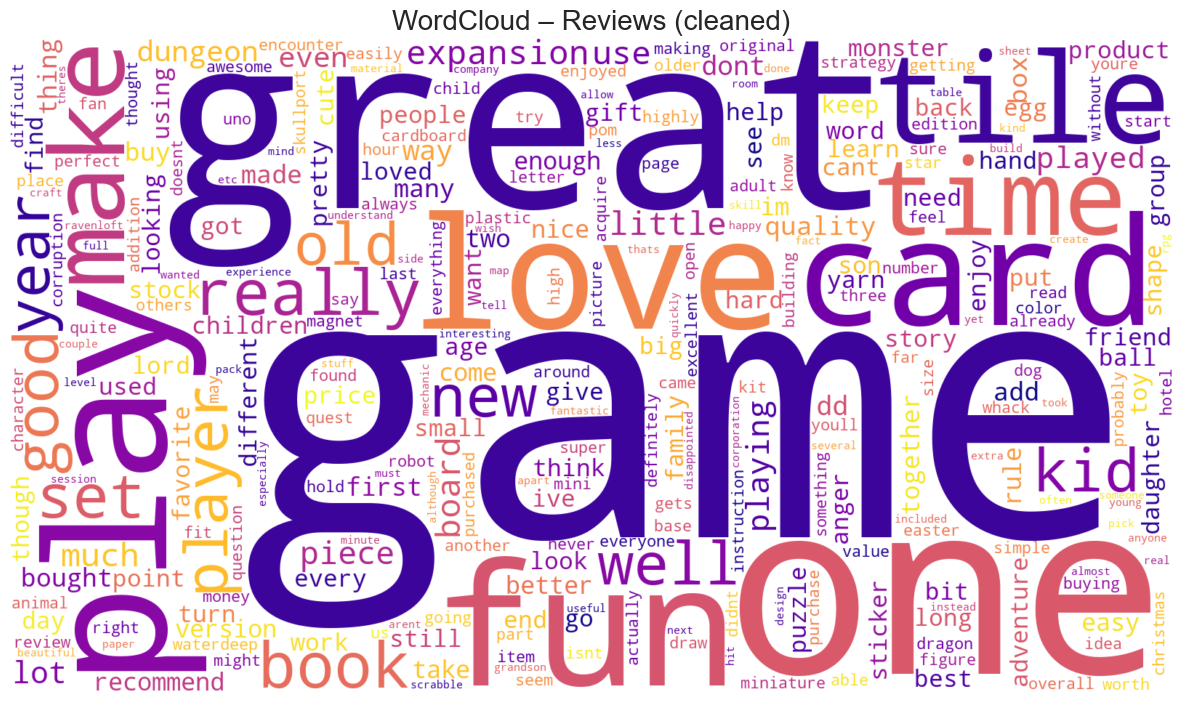

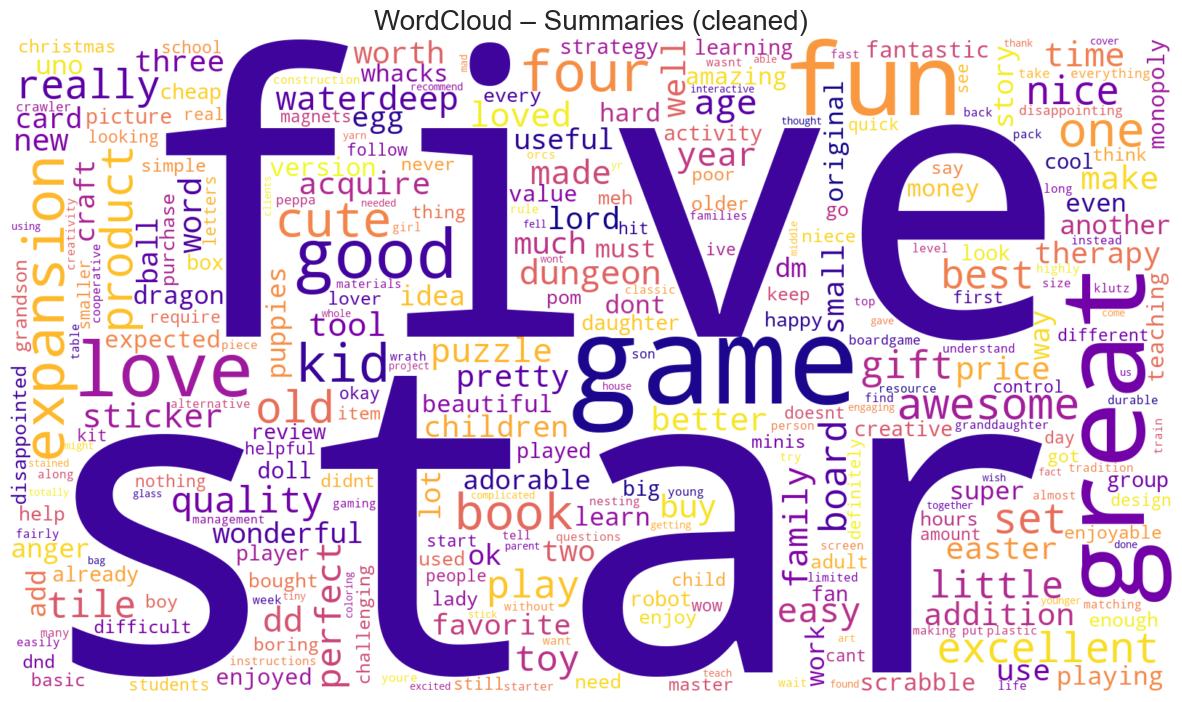

In [222]:
def plot_wordcloud(tokens, title, filename, seed=42):
    text = ' '.join(tokens)
    wc = WordCloud(
        width=1600,
        height=900,
        background_color='white',
        colormap='plasma',
        max_words=300,
        collocations=False,
        random_state=seed
    ).generate(text)

    plt.figure(figsize=(15, 9))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()

plot_wordcloud(all_review_tokens,  "WordCloud – Reviews (cleaned)",  "wc_reviews.png")
plot_wordcloud(all_summary_tokens, "WordCloud – Summaries (cleaned)", "wc_summaries.png")


### WordCloud Analysis

The WordCloud visualizations highlight the most frequently used words in the customer reviews and summaries after tokenization and removal of stop words.  

- **Reviews WordCloud**:  
  Key terms such as *game*, *play*, *love*, *fun*, and *card* dominate, indicating that customers frequently discuss the product type and their enjoyment. Positive emotional words (*love*, *fun*, *great*) suggest overall satisfaction, while terms like *tile*, *player*, and *board* highlight product-related features.

- **Summaries WordCloud**:  
  Prominent phrases like *five star*, *love*, *fun*, and *great* indicate overwhelmingly positive ratings in the review summaries. These words show that customers are not only satisfied but also willing to endorse the product. Product-specific terms (*puzzle*, *sticker*, *toy*) suggest popular item types among customers.

**Insight:**  
The dominance of positive sentiment words across both reviews and summaries suggests strong customer satisfaction, which can be leveraged in marketing messaging and product promotion.


In [226]:
# Frequency distributions of words
freq_review = FreqDist(all_reviews_filtered)
freq_summary = FreqDist(all_summaries_filtered)

In [227]:
print("Top 15 words in reviews:\n", freq_review.most_common(15))
print("Top 15 words in summaries:\n", freq_summary.most_common(15))

Top 15 words in reviews:
 [('game', 1671), ('great', 580), ('fun', 552), ('one', 530), ('play', 502), ('like', 414), ('love', 323), ('really', 319), ('get', 319), ('cards', 301), ('tiles', 297), ('time', 291), ('good', 289), ('would', 280), ('book', 273)]
Top 15 words in summaries:
 [('stars', 427), ('five', 342), ('game', 319), ('great', 295), ('fun', 218), ('love', 93), ('good', 92), ('four', 58), ('like', 54), ('expansion', 52), ('kids', 50), ('cute', 45), ('book', 43), ('one', 38), ('awesome', 36)]


### Word Frequency Insights

The most frequent terms in customer reviews and summaries revolve around **positive sentiment** (e.g., "great", "fun", "love") and **product usage** (e.g., "game", "play", "cards").  
This pattern indicates strong customer engagement and satisfaction, which can be leveraged in marketing campaigns by highlighting **fun, quality, and enjoyment** as key selling points.  
Frequent mentions of specific product types (e.g., "expansion", "kids") also point to opportunities for **targeted product development** and **segment-focused promotions**.


In [228]:
# Polarity function
def get_polarity(text):
    return TextBlob(text).sentiment.polarity


In [231]:
# Calculate polarity for review and summary
df['review_polarity'] = df['review'].apply(get_polarity)
df['summary_polarity'] = df['summary'].apply(get_polarity)


In [232]:
# Modular function for polarity histogram
def plot_polarity_hist(data, column, title, filename):
    plt.figure(figsize=(10,6))
    sns.histplot(data[column], bins=15, kde=True, color='steelblue')
    plt.title(title)
    plt.xlabel('Polarity')
    plt.ylabel('Frequency')
    plt.savefig(filename)
    plt.show()


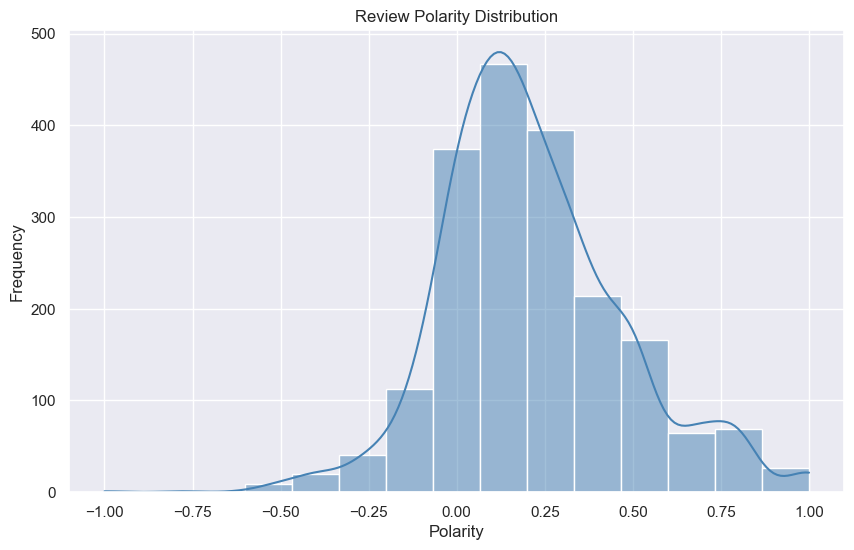

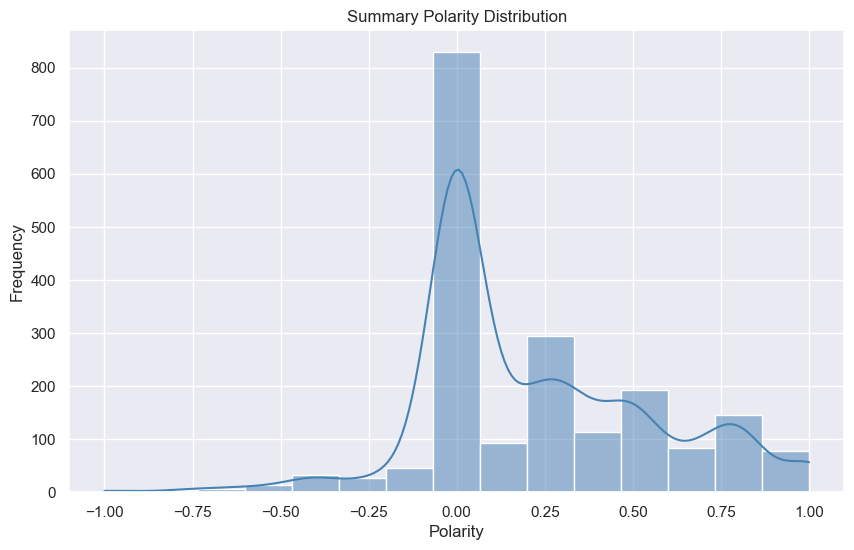

In [233]:
plot_polarity_hist(df, 'review_polarity', 'Review Polarity Distribution', 'review_polarity_hist.png')
plot_polarity_hist(df, 'summary_polarity', 'Summary Polarity Distribution', 'summary_polarity_hist.png')



**Sentiment Analysis Insights**  
Both reviews and summaries lean positive, with most polarity scores between 0 and +0.5.  
Reviews show a slightly wider sentiment spread, while summaries tend to cluster more tightly around neutral/positive.  
This suggests that customers are generally satisfied, but reviews reveal more detailed emotional variation — useful for identifying specific product strengths and weaknesses.


In [243]:
# Print top 20 positive and negative reviews
print("Top 20 positive reviews:")
print(df.nlargest(20, 'review_polarity')[['review', 'review_polarity']])
print("\nTop 20 negative reviews:")
print(df.nsmallest(20, 'review_polarity')[['review', 'review_polarity']])
print("\nTop 20 positive summaries:")


Top 20 positive reviews:
                                                 review  review_polarity
7                             came in perfect condition              1.0
165                                        awesome book              1.0
194                                        awesome gift              1.0
496   excellent activity for teaching selfmanagement...              1.0
524                         perfect just what i ordered              1.0
591                                   wonderful product              1.0
609                                  delightful product              1.0
621   wonderful for my grandson to learn the resurre...              1.0
790                                             perfect              1.0
933                                             awesome              1.0
1135                                        awesome set              1.0
1168               best set buy 2 if you have the means              1.0
1177               awesome

In [247]:
# Print top 20 positive and negative summaries
print("\nTop 20 positive summaries:")
print(df.nlargest(20, 'summary_polarity')[['summary', 'summary_polarity']])

print("\nTop 20 negative summaries:")
print(df.nsmallest(20, 'summary_polarity')[['summary', 'summary_polarity']])



Top 20 positive summaries:
                                               summary  summary_polarity
6                                  best gm screen ever               1.0
28                                   wonderful designs               1.0
32                                             perfect               1.0
80   theyre the perfect size to keep in the car or ...               1.0
134                            perfect for preschooler               1.0
140             awesome sticker activity for the price               1.0
161                                       awesome book               1.0
163                    he was very happy with his gift               1.0
187                                            awesome               1.0
210           awesome and welldesigned for 9 year olds               1.0
418                                            perfect               1.0
475                                          excellent               1.0
543                    

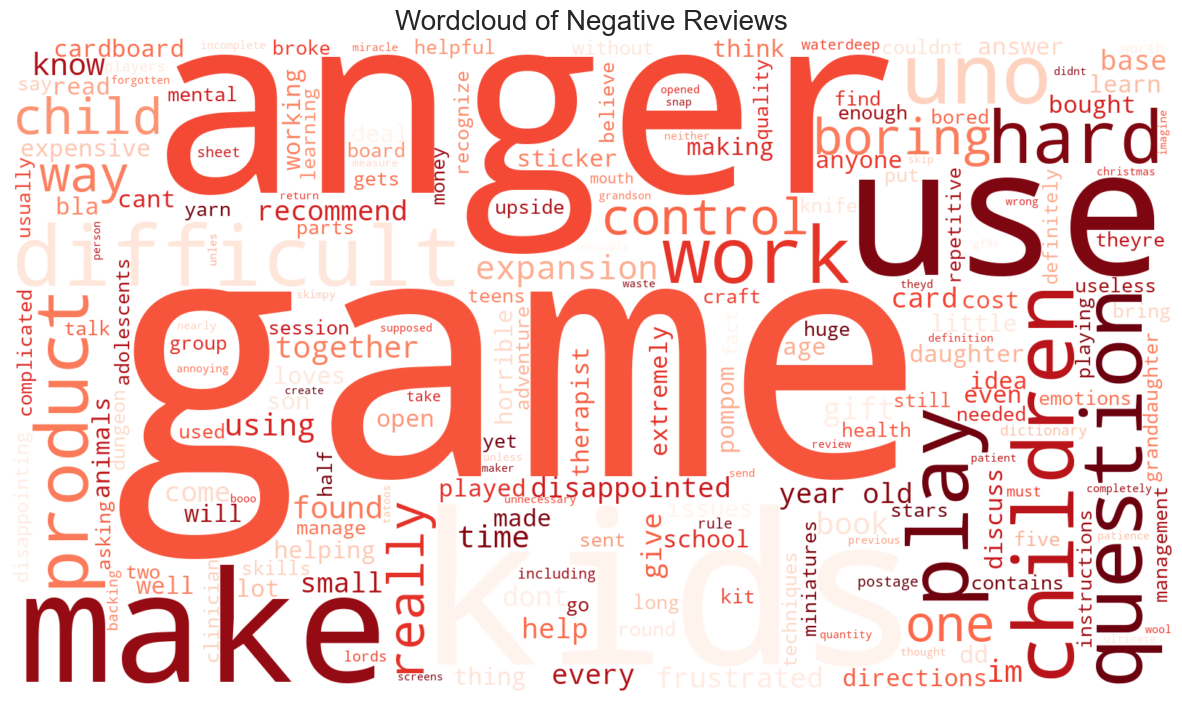

In [248]:
# Clean text function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    return text

# Apply cleaning
df['review'] = df['review'].apply(clean_text)

# Calculate sentiment polarity
df['review_polarity'] = df['review'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Filter reviews with strong negative sentiment
negative_reviews = df[df['review_polarity'] < -0.2]['review']

# Combine all text into one string
negative_text = ' '.join(negative_reviews)

# Optionally exclude common positive words that sneak into mixed reviews
positive_words = ['fun', 'great', 'love', 'enjoy', 'awesome', 'fantastic', 'like']
filtered_negative_words = ' '.join([word for word in negative_text.split() if word not in positive_words])

# Generate and display the wordcloud
wordcloud = WordCloud(
    width=1600,
    height=900,
    background_color='white',
    colormap='Reds',
    min_font_size=10
).generate(filtered_negative_words)

plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of Negative Reviews', fontsize=20)
plt.savefig('negative_review_wordcloud_cleaned.png')
plt.show()



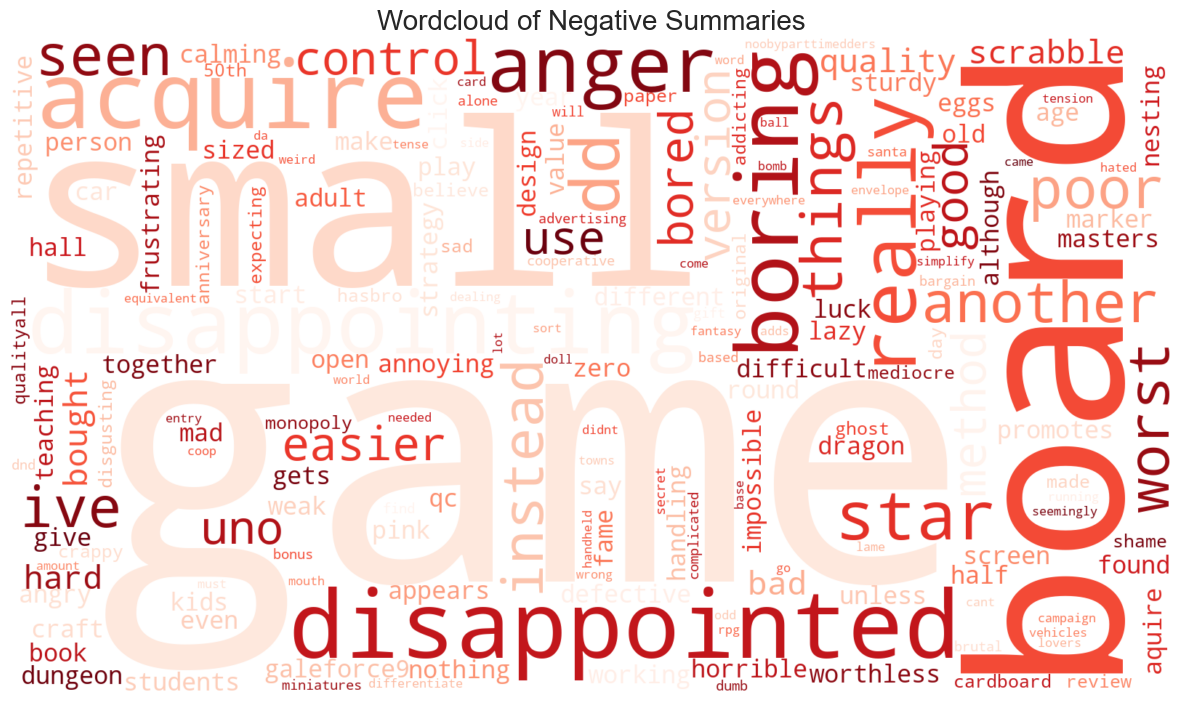

In [249]:
# Generate wordcloud for negative summaries
negative_summaries = df[df['summary_polarity'] < -0.2]['summary']
negative_summary_text = ' '.join(negative_summaries)

filtered_negative_summary = ' '.join([word for word in negative_summary_text.split() if word not in positive_words])

wordcloud_sum = WordCloud(
    width=1600,
    height=900,
    background_color='white',
    colormap='Reds',
    min_font_size=10
).generate(filtered_negative_summary)

plt.figure(figsize=(15, 9))
plt.imshow(wordcloud_sum, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of Negative Summaries', fontsize=20)
plt.savefig('negative_summary_wordcloud_cleaned.png')
plt.show()

Negative Sentiment Insights:
Recurring negative terms like "anger", "difficult", "disappointed", and "boring" signal potential product and user experience issues. Addressing these pain points through improved game design, clearer instructions, and better quality control could directly enhance customer satisfaction and reduce churn.

## 📝 NLP Insights: Customer Feedback Analysis
# Summary

Natural Language Processing (NLP) was applied to customer reviews and summaries to identify key themes and sentiment trends.

Positive Themes: Word clouds of all reviews and summaries revealed dominant words such as "game," "great," "fun," and "love," indicating a generally favorable customer experience.

Negative Themes: A separate analysis of strongly negative sentiment revealed recurring terms such as 'anger,' 'difficult,' 'disappointed,' and 'boring,' highlighting specific product pain points.

Sentiment Distribution: Both reviews and summaries skew positive; however, notable negative outliers suggest that specific customer segments have unmet expectations.

# Business Recommendations

Improve Product Quality: Address recurring complaints around difficulty and product issues by refining design, enhancing materials, and increasing quality control.

Enhance User Experience: Simplify gameplay or instructions to reduce frustration and complexity for new players.

Targeted Customer Support: Proactively reach out to dissatisfied customers identified via sentiment monitoring to rebuild trust.

Product Development Feedback Loop: Incorporate sentiment insights into the design process to ensure new releases better align with customer preferences.

## 📊 Final Project Summary & Business Recommendations
Overview

This Python-based analytics project combined multiple machine learning and data analysis techniques to explore customer behavior, predict loyalty points, segment users, and extract insights from reviews.
The workflow covered:

Regression Modeling – Predicted loyalty points using remuneration, spending score, and age.

Decision Tree Analysis – Interpreted key drivers of loyalty, revealing spending score and remuneration as primary predictors.

K-Means Clustering – Segmented customers into five distinct groups for targeted marketing.

NLP & Sentiment Analysis – Analyzed customer feedback to uncover positive themes and areas needing improvement.

Key Insights
1. Regression & Decision Trees

Spending score and remuneration have the most decisive influence on loyalty points.

Customers with higher spending scores tend to show significantly higher loyalty engagement.

2. Customer Segmentation (K-Means)

Five unique customer clusters were identified, ranging from high-income/low-spending to low-income/high-spending segments.

This segmentation enables precision targeting in marketing campaigns.

3. NLP & Sentiment Analysis

Positive feedback centers around fun, quality, and enjoyment.

Negative sentiment focuses on complexity, quality issues, and product durability.

Sentiment polarity distribution is skewed toward the positive, but a visible minority of strongly negative reviews highlights opportunities for improvement.

Business Recommendations
Product Strategy

Enhance quality control to address recurring issues around product durability.

Simplify onboarding for new players by improving instructions and gameplay clarity.

Marketing & Loyalty

Personalize campaigns for high-value clusters identified in segmentation.

Re-engage low-loyalty high-income customers with exclusive offers and tailored promotions.

Customer Feedback Integration

Establish a feedback loop using sentiment analysis to track product reception in real time.

Proactively address common pain points highlighted in negative sentiment clusters.
## Conclusion

This project demonstrates how combining predictive modeling, customer segmentation, and NLP-driven sentiment analysis can guide data-driven business decisions.
By aligning product development, marketing, and customer experience strategies with these insights, the company can boost loyalty, improve satisfaction, and drive revenue growth.